# Create a meshed screen to receive the emitted diffraction radiation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.special as func
from scipy import constants
from MeshedFields import *

The test case computes the diffraction radiation for $\gamma$=20.
So the screen has to intercept at least a 2/$\gamma$=0.1 opening angle.

In [2]:
mesh = MeshedField.CircularMesh(R=1.0, ratio=1.0, lcar=0.08)
print("%d points" % len(mesh.points))
print("%d triangles" % len(mesh.triangles))

712 points
1338 triangles


Modify the points so that the screen is positioned at z=-3 m from the origin with the normal pointing in positive z direction.

In [3]:
pts = [np.array([-p[0],p[1],-3.0]) for p in mesh.points]
target = MeshedField(pts, mesh.triangles)

In [4]:
target.BoundingBox()

((-1.0, 1.0), (-1.0, 1.0), (-3.0, -3.0))

In [5]:
normals = target.MeshNormals()
print(np.sum(normals, axis=0)/target.Np)

[ 0.  0.  1.]


In [6]:
area = target.MeshArea()
print(np.pi*np.square(0.05)*np.sqrt(2.0))
print(np.sum(area))

0.0111072073454
3.13836382911


### setup the timing of the cells

The peak of the wave packet is assumed to start at the origin at t=0. The arrival time of the signal corresponds to an observation points distance from the origin.

The start time of the traces is 200 steps before the expected time of arrival which is computed as the distance of the observation point divided by the speed of light. The length is 800 steps what accounts for some propagation lines having greater length.

In [7]:
print(3.0/constants.c)

1.0006922855944561e-08


In [8]:
# time step
target.dt = 2.0e-13
# all points use the same timing grid
target.Nt = 500

target.t0 = np.array([np.linalg.norm(p)/constants.c -200*target.dt for p in target.pos])
print(np.min(target.t0))
print(np.max(target.t0)+target.Nt*target.dt)
print(len(target.t0))

9.9678626628e-09
1.0592374241e-08
1338


estimated memory requirements

In [9]:
8*target.Np*target.Nt*6

32112000

## check geometry and write to file

In [10]:
target.ShowMeshedField(showCenters=False,showAxes=True)

In [11]:
filename="../tests/BackwardDiffractionScreen.h5"
target.WriteMeshedField(filename)

not writing ElMagField dataset


## check the source file

corner points :  (777, 3)
triangles :  (1462, 3)
Nt = 500   dt = 2e-13 
t0 :  (1462,)
field :  (1462, 500, 6)
-5e-11
-5e-11
peak energy density = 0.018865 J/m² at cell 1262
total pulse energy = 0.470 µJ
total energy flow vector = [ -2.18168754e-09  -1.66796572e-09   4.70230834e-01] µJ


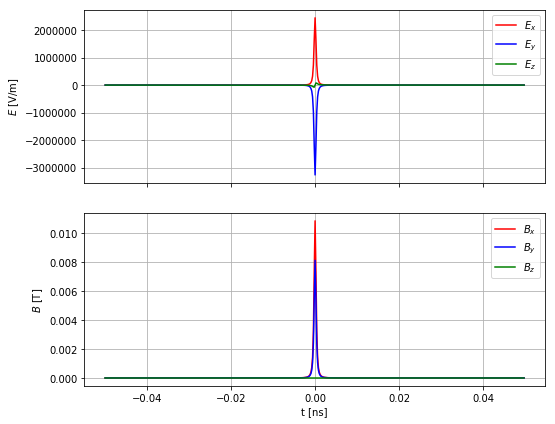

In [13]:
filename="../tests/DiffractionScreenWithFields.h5"
source = MeshedField.ReadMeshedField(filename)

print(np.min(source.t0))
print(np.max(source.t0))

area = source.MeshArea()
S = [np.linalg.norm(source.EnergyFlowVector(i)) for i in range(source.Np)]
PeakIndex = np.argmax(S)
SV = np.sum([source.EnergyFlowVector(i)*area[i] for i in range(source.Np)],axis=0)
Pz = [source.NormalEnergyFlow(i) for i in range(source.Np)]

print("peak energy density = %.6f J/m² at cell %d" % (np.max(S),PeakIndex))
print("total pulse energy = %.3f µJ" % (1e6*np.dot(area,Pz)))
print("total energy flow vector = %s µJ" % (1e6*SV))

source.ShowMeshedField(scalars=Pz,scalarTitle="Pz",highlight=[PeakIndex])
source.ShowFieldTrace(PeakIndex)

## check the target file after propagation

In [12]:
filename="../tests/BackwardDiffractionFields.h5"
computed = MeshedField.ReadMeshedField(filename)

print("%d points" % len(computed.points))
print("%d triangles" % len(computed.triangles))
area = computed.MeshArea()
normals = computed.MeshNormals()
average = np.sum(normals, axis=0)/computed.Np
print("total mesh area = %7.3f cm²" % (1.0e4*np.sum(area)))
print("screen normal = %s" % average)

corner points :  (712, 3)
triangles :  (1338, 3)
Nt = 500   dt = 2e-13 
t0 :  (1338,)
field :  (1338, 500, 6)
712 points
1338 triangles
total mesh area = 31383.638 cm²
screen normal = [ 0.  0.  1.]


In [13]:
area = computed.MeshArea()
S = [np.linalg.norm(computed.EnergyFlowVector(i)) for i in range(computed.Np)]
peak_index = np.argmax(S)
Pz = [computed.NormalEnergyFlow(i) for i in range(computed.Np)]

print("peak energy density = %.6f J/m²  index=%d" % (S[peak_index],peak_index))
print("total pulse energy = %.3f µJ" % (1e6*np.dot(area,Pz)))

peak energy density = 0.000001 J/m²  index=324
total pulse energy = 0.311 µJ


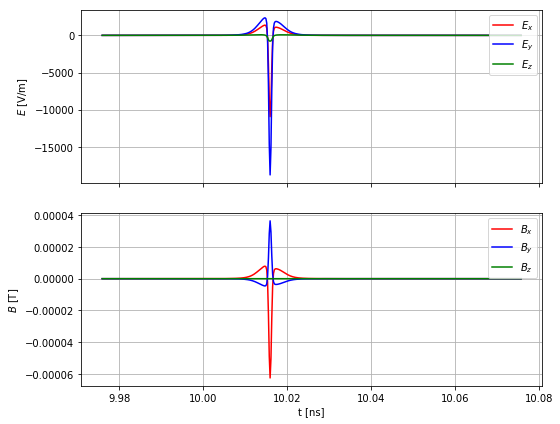

In [14]:
computed.ShowMeshedField(scalars=Pz,scalarTitle="Pz",highlight=[peak_index],showGrid=True)
computed.ShowFieldTrace(peak_index)

cell No. 116 pos=[ 0.1447055  -0.02997943 -3.        ]
pointing vector S=[ -2.39866184e-08   4.96724580e-09  -6.90145760e-07]


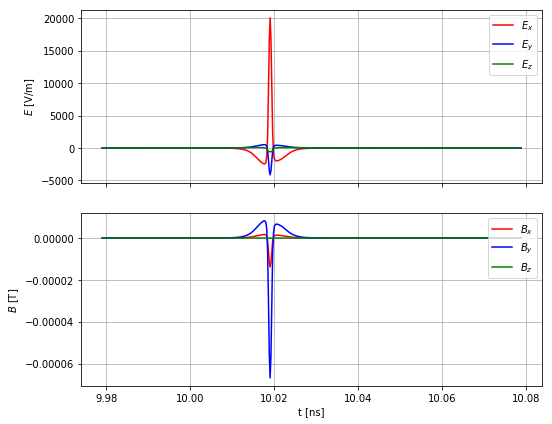

cell No. 337 pos=[ 0.86538513 -0.00594971 -3.        ]
pointing vector S=[ -5.13506266e-11   5.11295625e-13  -2.38435453e-08]


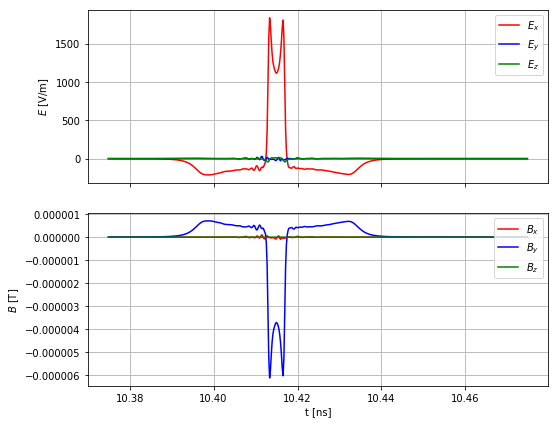

In [15]:
def pick(id):
    if id>0 and id<computed.Np:
        print("cell No. %d pos=%s" % (id,computed.pos[id]))
        print("pointing vector S=%s" % computed.EnergyFlowVector(id))
        computed.ShowFieldTrace(id)

computed.ShowMeshedField(scalars=Pz,scalarTitle="Pz",pickAction=pick,showGrid=False)

In [16]:
Q = 100.0e-12
N_e = Q / constants.e
N_e_sq = N_e * N_e
γ = 20
β = np.sqrt(1-1/(γ*γ))

ugf_0 = np.power(constants.e,2) /( 4*np.power(np.pi,3)*constants.epsilon_0*constants.c)
def d2Ugf(β,Θ):
    return ugf_0 * (np.power(β,2)*np.power(np.sin(Θ),2))/np.power(1-np.power(β,2)*np.power(np.cos(Θ),2),2)
def T(ω,Θ,a):
    arg1 = ω*a/(β*γ*constants.c)
    arg2 = ω*a*np.sin(Θ)/constants.c
    arg3 = ω*a/(constants.c*np.power(β*γ,2)*np.sin(Θ))
    return arg1*func.j0(arg2)*func.k1(arg1)+arg3*func.j1(arg2)*func.k0(arg1)
def TT(ω,Θ,a1,a2):
    return np.square(T(ω,Θ,a1)-T(ω,Θ,a2))

def angular_integral(ω_i,r_i,r_a):
    def dUdωdΘ(Θ):
        return d2Ugf(β,Θ)*2*np.pi*np.sin(Θ)
    def spect_integrand(Θ):
        return dUdωdΘ(Θ)*TT(ω_i,Θ,r_i,r_a)
    integral = scipy.integrate.quadrature(spect_integrand,0,np.pi/2,tol=1e-40,rtol=1e-6,miniter=20,maxiter=400)
    return integral[0]

f_th = np.power(10.0,np.linspace(-2.0,1.0,300))
th1 = np.array([angular_integral(2*np.pi*f*1e12,0.002,0.030) for f in f_th])*2*np.pi*1e9
E_opt = 1000*N_e_sq * scipy.integrate.trapz(th1,f_th)
print("total pulse energy (100pC) = %g µJ" % E_opt)

total pulse energy (100pC) = 4.62938e-07 µJ


total pulse energy = 0.311389 µJ


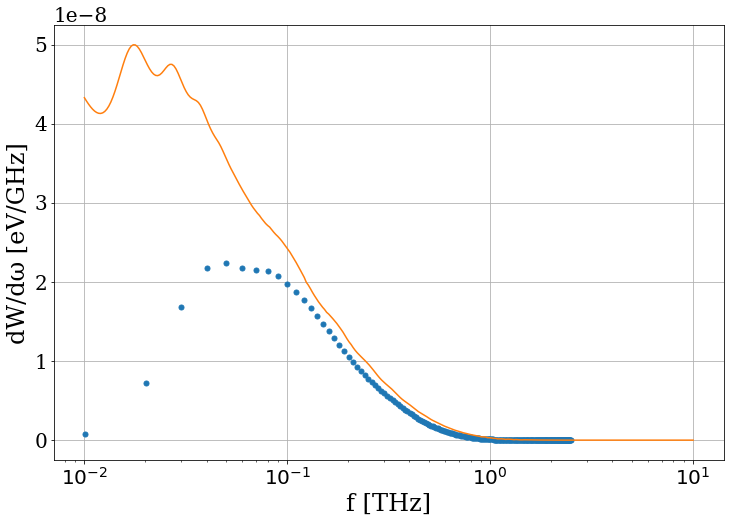

In [17]:
nele = Q/constants.e
nots = computed.Nt
nf = nots
dt = computed.dt
df = 1.0/dt/nf
fmax = 1.0/dt

f = np.linspace(0.0,fmax,nf)[:nots//2]
spectrum = np.zeros(nots//2)

for index in range(computed.Np):
    trace = computed.A[index]
    data = trace.transpose()
    Ex = data[0]
    Ey = data[1]
    Ez = data[2]
    Bx = data[3]
    By = data[4]
    Bz = data[5]
    spectEx = np.fft.fft(Ex)[:nots//2]
    spectEy = np.fft.fft(Ey)[:nots//2]
    spectEz = np.fft.fft(Ez)[:nots//2]
    spectBx = np.fft.fft(Bx)[:nots//2]
    spectBy = np.fft.fft(By)[:nots//2]
    spectBz = np.fft.fft(Bz)[:nots//2]
    amp = np.abs(spectEx*np.conj(spectBy)-spectEy*np.conj(spectBx))/constants.mu_0*2*dt/(df*nf)
    spectrum += amp*area[index]

E_opt = scipy.integrate.trapz(spectrum,f)
print("total pulse energy = %g µJ" % (1e6*E_opt))

plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["font.family"] = 'serif'
plt.rcParams["font.size"] = 20
plt.rcParams['axes.labelsize'] = 'large'
fig, ax = plt.subplots()
ax.semilogx(1e-12*f,1e9*spectrum/(nele*nele)/constants.e,marker='.',markersize=10.0,linestyle='None')
ax.semilogx(f_th,th1/constants.e)
ax.set_xlabel('f [THz]')
ax.set_ylabel('dW/dω [eV/GHz]')
ax.grid()